**Customer segmentation** is the process of segregating a company’s potential customer base into discrete groups based on their needs, buying characteristics, etc. By doing so, businesses can better target individuals and augment sales by providing the customers with more tailored shopping experiences.

In this jupyter notebook, I will be using K Means Clustering in Python.

The main libraries involved in this tutorial are:

- **pandas** for data manipulation and ingestion
- **matplotlib** and **seaborn** for data visualization
- **numpy** for multidimensional array computing
- **sklearn** for machine learning and predictive modeling

In [329]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [330]:
data = pd.read_csv(r'C:\Projects\Customer-Segmentation\dataset\Mall_Customers.csv', index_col='CustomerID')
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [331]:
data.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

Here, some of the columns contain symbols and numerical characters. Though it won't affect anything in our further analysis, but for presentation, removing those extra characters.

In [332]:
data.rename(columns = {'Annual Income (k$)':'Annual Income', 'Spending Score (1-100)':'Spending Score'}, inplace = True)

In [333]:
data.head()

,Gender,Age,Annual Income,Spending Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


The information about the other 4 features are as follows:

- **Gender**: It is a categorical data type which contains two categorical values (male,female) and must be converted to numeric before using for further analysis.
- **Age**: It is a numerical data type and contains age of people.
- **Annual Income**: It is a numerical data type and contains annual income in 1000 dollars.
- **Spending Score**: It is a numerical data type and contains a score between 1–100 for a customer based on their spending behavior.

# Handling Outliers

For detecting the outliers in our dataset, we will be using boxplot.

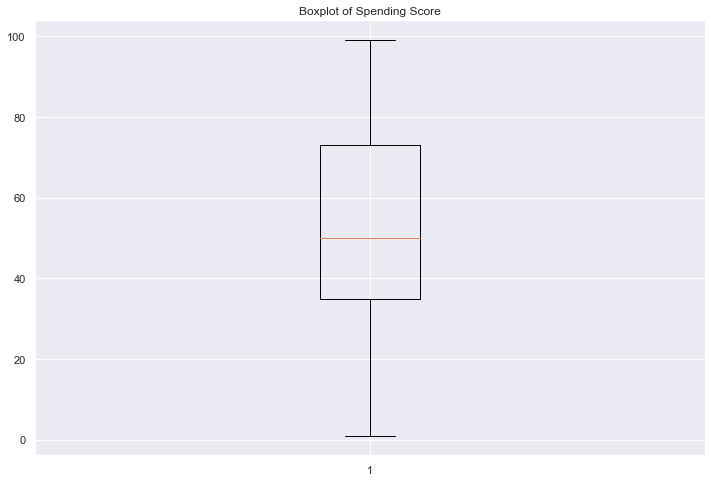

In [334]:
plt.figure(figsize=(12,8))
plt.boxplot(data['Spending Score'])
plt.title('Boxplot of Spending Score')
plt.show()

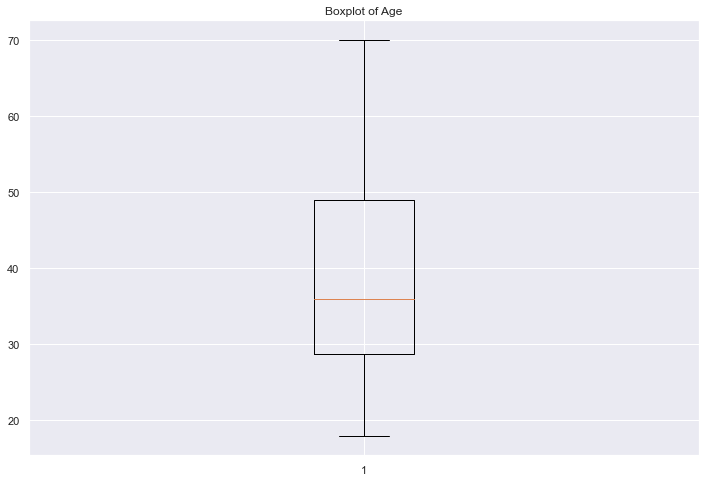

In [335]:
plt.figure(figsize=(12,8))
plt.boxplot(data['Age'])
plt.title('Boxplot of Age')
plt.show()

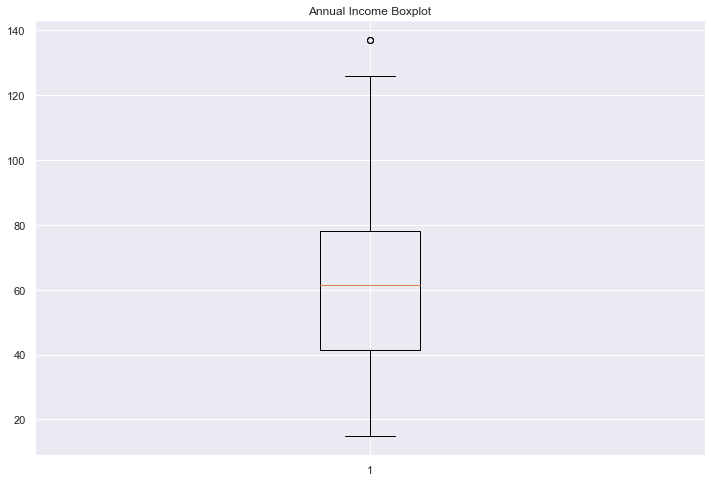

In [336]:
plt.figure(figsize=(12,8))
plt.boxplot(data['Annual Income'])
plt.title('Annual Income Boxplot')
plt.show()

The figure shows that there are a few outliers in the ‘Annual Income’ column. We will handle these outliers using the IQR or the interquartile range method.

In [337]:
Q1=np.percentile(data['Annual Income'],25,interpolation='midpoint')
Q2=np.percentile(data['Annual Income'],50,interpolation='midpoint')
Q3=np.percentile(data['Annual Income'],75,interpolation='midpoint')

IQR=Q3-Q1
lower_limit=Q1 - 1.5*IQR
upper_limit=Q3 + 1.5*IQR

outlier=[]

for x in data['Annual Income']:
    if((x>upper_limit)or(x<lower_limit)):
        outlier.append(x)

In [338]:
outlier

[137, 137]

The value of two outliers are found out to be [137,137]. Next we will be finding out the rows which contains these values and remove them.


In [339]:
outlier_index=data['Annual Income']>upper_limit
data.loc[outlier_index].index

Int64Index([199, 200], dtype='int64', name='CustomerID')

Row 199th and 200th contains those outliers. Subsequently deleting them.

In [340]:
data.drop([199, 200],inplace=True)

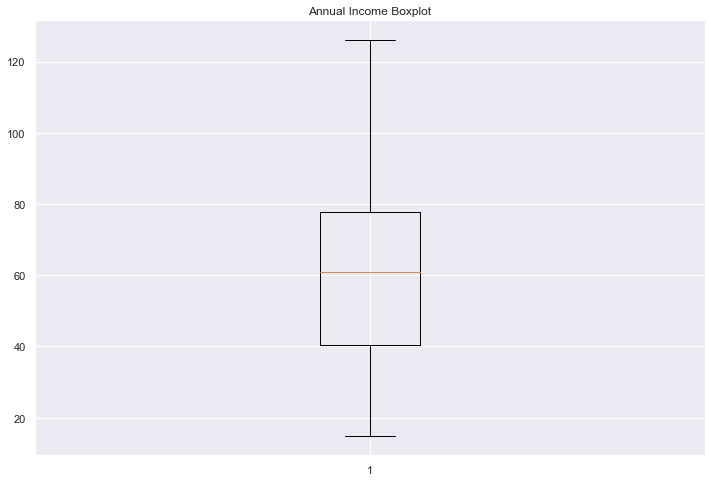

In [341]:
#checking too see if the outliers were removed 
plt.figure(figsize=(12,8))
plt.boxplot(data['Annual Income'])
plt.title('Annual Income Boxplot')
plt.show()

Our feature 'Annual Income' is now free from any outlier.

# EDA and Data Visualization

## Univariate Analysis

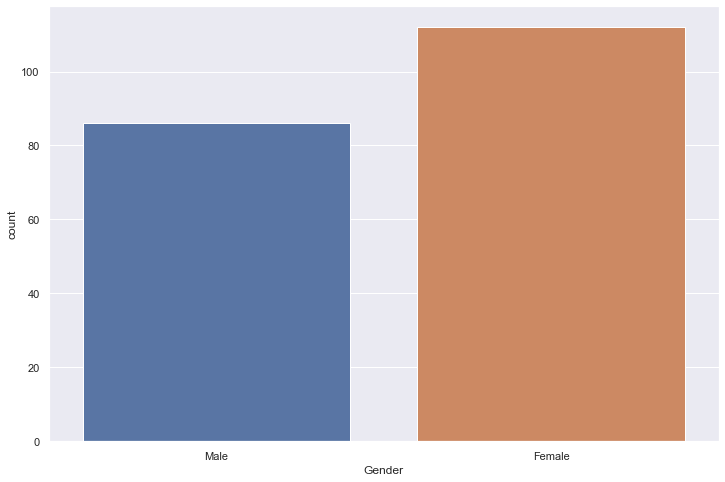

In [342]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.countplot(data['Gender'])

From the plot, we can observe there are more females in the dataset when compared to males.

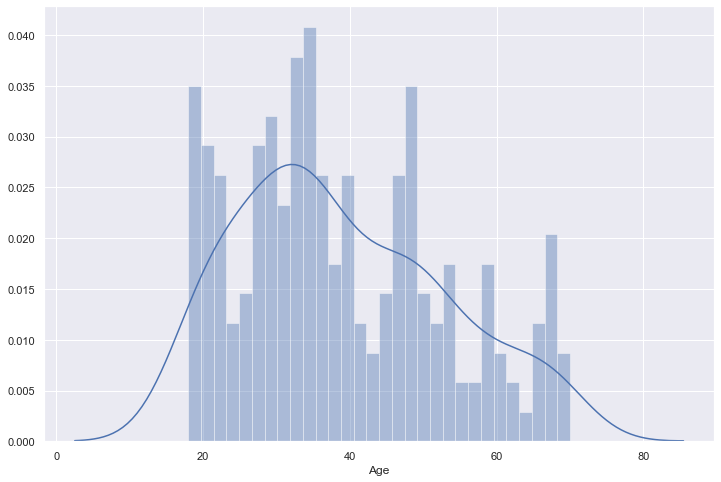

In [343]:
sns.distplot(data['Age'], bins=30)

From the plot, it is clearly visible that the age column contains values that are almost normally distributed. The KDE on the distplot looks like a bell curve, meaning the majority of data points of the ‘Age’ column are relatively similar.

## Treating the categorical feature

Since, the categorical variables must be pre-processed before deploying the model, we will be converting our only categotical feature, 'Gender' by mapping each of its unique value 'Male'and 'Female' to 0 and 1 respectively.

In [344]:
gender= {'Male':0, 'Female':1}
data['Gender']= data['Gender'].map(gender)

In [345]:
data.head()

,Gender,Age,Annual Income,Spending Score
CustomerID,,,,
1,0,19,15,39
2,0,21,15,81
3,1,20,16,6
4,1,23,16,77
5,1,31,17,40


## Bivariate Analysis

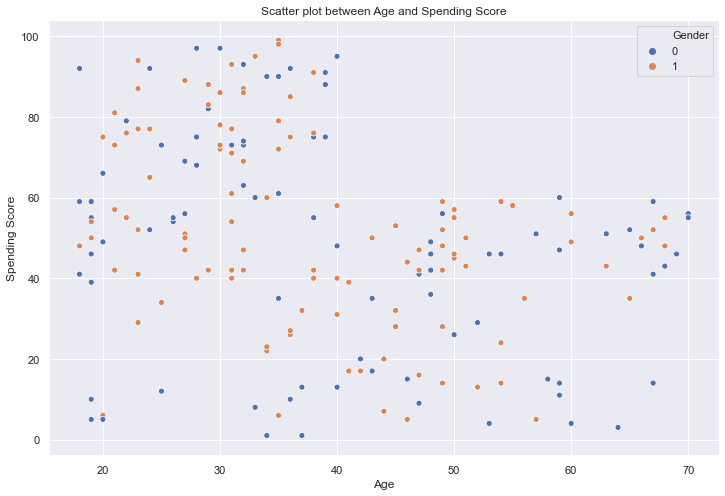

In [346]:
plt.figure(figsize=(12,8))
sns.scatterplot('Age','Spending Score',hue='Gender',data=data);
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Scatter plot between Age and Spending Score')
plt.show()

People between the age group of 20-40 roughly have the highest spending score or in other words, lower the age higher the spending score

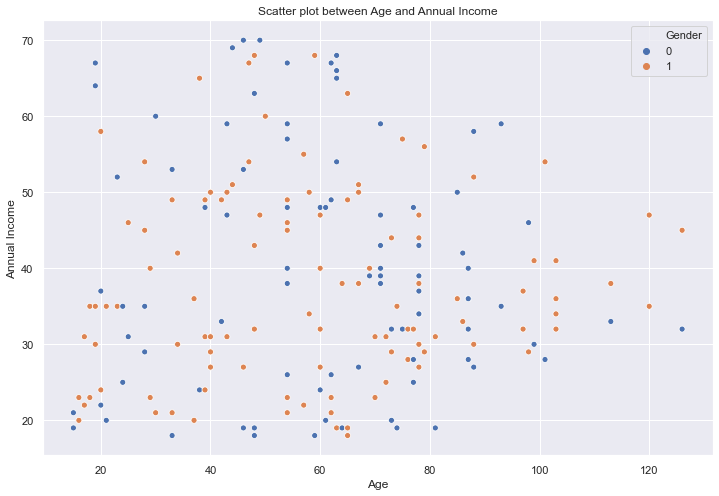

In [347]:
plt.figure(figsize=(12,8))
sns.scatterplot('Annual Income','Age',hue='Gender',data=data);
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.title('Scatter plot between Age and Annual Income')
plt.show()

It can be concluded from the above scatter plot that people between the age group of 30-50 get the highest income.

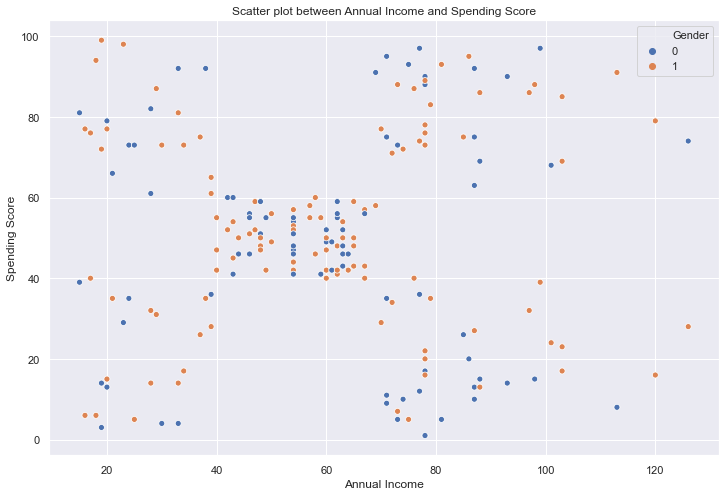

In [348]:
plt.figure(figsize=(12,8))
sns.scatterplot('Annual Income','Spending Score',hue='Gender',data=data)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Scatter plot between Annual Income and Spending Score')
plt.show()

We can see that roughly Annual income of $40-60k corresponds to 40-60 spending score.

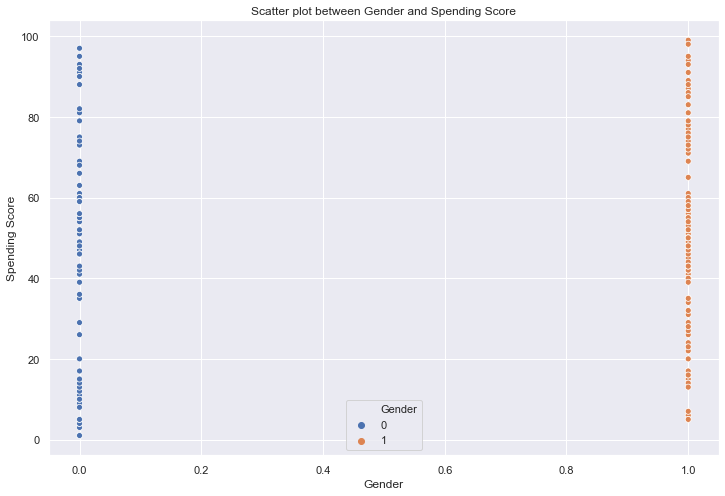

In [349]:
plt.figure(figsize=(12,8))
sns.scatterplot('Gender','Spending Score',hue='Gender',data=data);
plt.xlabel('Gender')
plt.ylabel('Spending Score')
plt.title('Scatter plot between Gender and Spending Score')
plt.show()

The spending score correspoding to females (mapped to 1) is slighlty higher than the spending score of males. Females are slightly more likely to spend more.

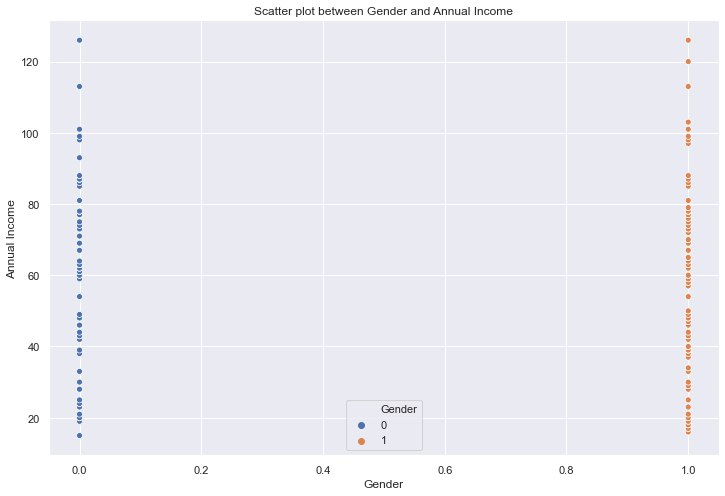

In [350]:
plt.figure(figsize=(12,8))
sns.scatterplot('Gender','Annual Income',hue='Gender',data=data);
plt.xlabel('Gender')
plt.ylabel('Annual Income')
plt.title('Scatter plot between Gender and Annual Income')
plt.show()

There is hardly any difference in the annual income of both genders after removing outliers

Now, let's check correlation among features using heatmap.

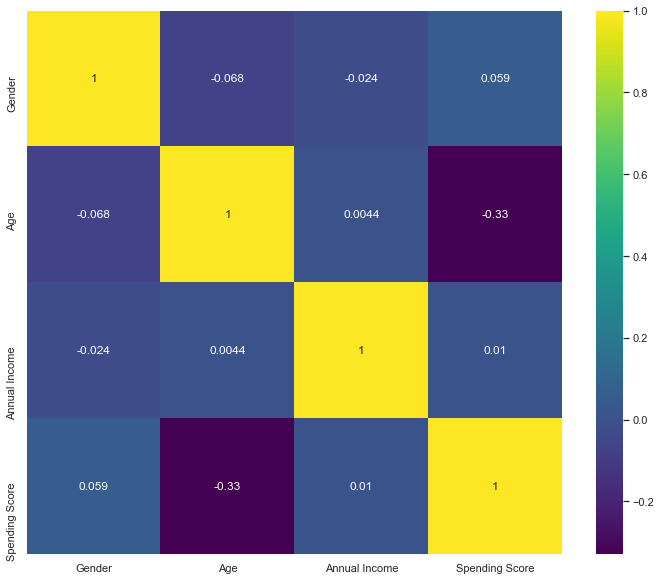

In [351]:
fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.corr(), annot=True, cmap='viridis')
plt.show()

- From the above heatmap, we can find that 'Age' is negatively correlated with 'Spending Score'.
- 'Annual Income' is very less correlated with 'Age'
- 'Gender' is very less correlated with 'Spending Score' but more correlated, when compared to 'Annual Income'

## Standardization of Features

Before we deploy the model, we will have to standardize all variables in the dataset to get them around the same scale. 

In [352]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Age', 'Annual Income', 'Spending Score']])

In [353]:
scaled_data

array([[-1.42541358, -1.77917141, -0.43598941],
       [-1.2823665 , -1.77917141,  1.19941337],
       [-1.35389004, -1.73944701, -1.72094874],
       [-1.13931942, -1.73944701,  1.04366072],
       [-0.5671311 , -1.69972262, -0.39705125],
       [-1.21084296, -1.69972262,  1.00472256],
       [-0.28103694, -1.65999822, -1.72094874],
       [-1.13931942, -1.65999822,  1.70560947],
       [ 1.79314572, -1.62027383, -1.83776323],
       [-0.63865464, -1.62027383,  0.84896992],
       [ 2.00771635, -1.62027383, -1.40944345],
       [-0.28103694, -1.62027383,  1.90030028],
       [ 1.36400448, -1.58054943, -1.37050529],
       [-1.06779588, -1.58054943,  1.04366072],
       [-0.13798986, -1.58054943, -1.44838161],
       [-1.21084296, -1.58054943,  1.12153705],
       [-0.28103694, -1.54082504, -0.59174206],
       [-1.35389004, -1.54082504,  0.61534095],
       [ 0.93486324, -1.46137625, -0.82537103],
       [-0.28103694, -1.46137625,  1.86136212],
       [-0.28103694, -1.42165185, -0.591

# Building the clustering model

In [354]:
#create a copy of the data variable
x = data.copy()

In [355]:
# The number in the brackets is K, or the number of clusters we are aiming for, here we take 3 randomly
kmeans = KMeans(3)
# Fit the data
kmeans.fit(x)

KMeans(n_clusters=3)

In [356]:
# Create a copy of the input data
clusters = x.copy()
# Take note of the predicted clusters 
clusters['cluster_pred']=kmeans.fit_predict(x)

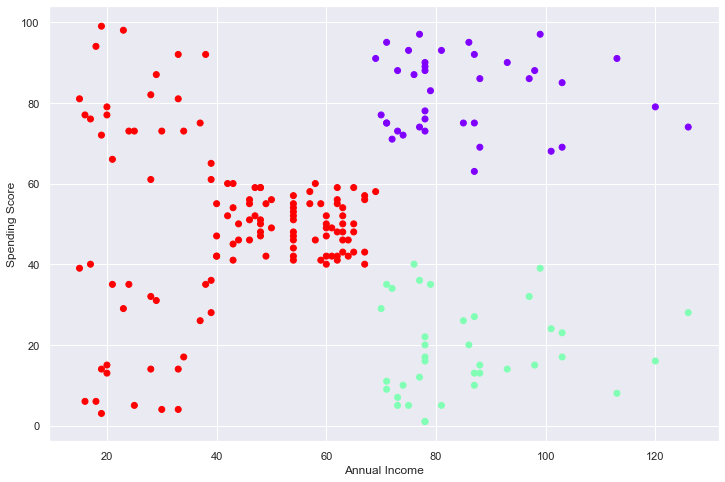

In [357]:
# Plot the data using the Annual Income and the Spending Score 
plt.scatter(clusters['Annual Income'],clusters['Spending Score'],c=clusters['cluster_pred'],cmap='rainbow')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()

The above scatter plot gives us a rough idea of the optimal number of clusters. But to find the most appropriate ‘K’, we use The Elbow Method.

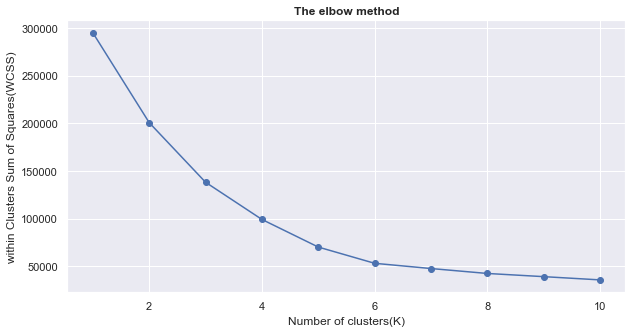

In [358]:
wcss=[]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                    max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(x)
    wcss_iter=kmeans.inertia_
    wcss.append(wcss_iter)
    
# Plotting the results onto a line graph to help us observe 'The Elbow'
plt.figure(figsize=(10,5))
no_clusters=range(1,11)
plt.plot(no_clusters, wcss,marker = "o")
plt.title('The elbow method', fontweight="bold")
plt.xlabel('Number of clusters(K)')
plt.ylabel('within Clusters Sum of Squares(WCSS)')
plt.show()

A silhouette score is a metric used to measure how dense and well separated the clusters are. The metric ranges from -1 to 1.

The higher the silhouette score, the better the model as it measures the distance between a data point and the data points in the nearest cluster.
<br>Let's check out that.

In [359]:
#Finding out the silhouette score to see if we have built a good model
print(silhouette_score(clusters, kmeans.labels_, metric='euclidean'))

0.37335868313961745


The silhouette score for the model is 0.37 which is a pretty decent value.

Now we assign the optimal number of clusters as 5 and create a new data frame with the predicted clusters. Moreover, we map our categorical feature ‘Gender’ back to its initial categories.

In [360]:
#assign the optimal number of clusters as 5
kmeans_new = KMeans(5)
# Fit the data
kmeans_new.fit(x)
# Create a new data frame with the predicted clusters
clusters_new = x.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(x)

#mapping the gender variable back to 'male' and 'female'
gender= {0:'Male',1:'Female'}
clusters_new['Gender']= clusters_new['Gender'].map(gender)

In [361]:
# Check if everything seems right
clusters_new.head()

,Gender,Age,Annual Income,Spending Score,cluster_pred
CustomerID,,,,,
1,Male,19,15,39,4
2,Male,21,15,81,2
3,Female,20,16,6,4
4,Female,23,16,77,2
5,Female,31,17,40,4


## Cluster Analysis

To get a more comprehensible understanding of the predicted clusters, let’s visualize.

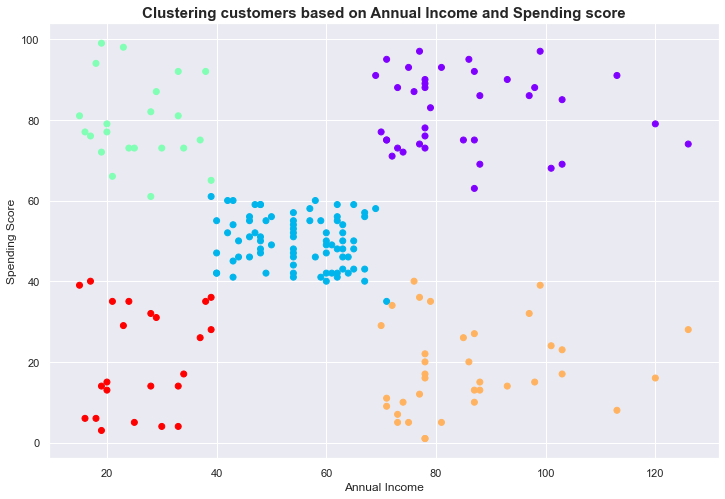

In [362]:
#Plotting the finally made clusters
plt.figure(figsize=(12,8))
plt.scatter(clusters_new['Annual Income'],clusters_new['Spending Score'],c=clusters_new['cluster_pred'],cmap='rainbow')
plt.title("Clustering customers based on Annual Income and Spending score", fontsize=15,fontweight="bold")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

On the basis of the above graph, we can say that the clusters represent the following 5 groups:

1. **Orange**: High annual income, High Spending score

2. **Red**: Low annual income, High spending score

3. **Green**: High annual income, Low spending score

4. **Violet**: Low annual income, Low spending score

5. **Blue**: Intermediate annual income, Intermediate spending score

In [363]:
#To compare attributes of the different clusters, lets find the average of all variables across each cluster
avg_data = clusters_new.groupby(['cluster_pred'], as_index=False).mean()
avg_data

,cluster_pred,Age,Annual Income,Spending Score
0,0,32.763158,85.210526,82.105263
1,1,43.126582,54.822785,49.835443
2,2,25.272727,25.727273,79.363636
3,3,40.555556,86.055556,18.194444
4,4,45.217391,26.304348,20.913043


Let’s visualize the above table using bar graphs.

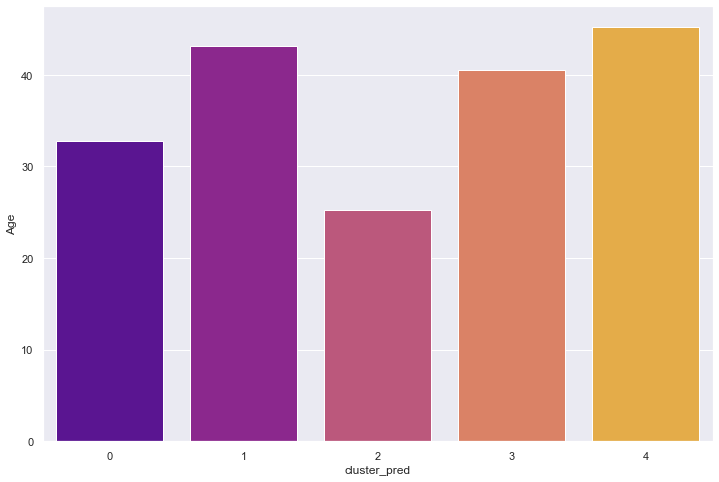

In [364]:
#To get a clearer picture, we use visualizations
sns.barplot(x='cluster_pred',y='Age',palette="plasma", data=avg_data)

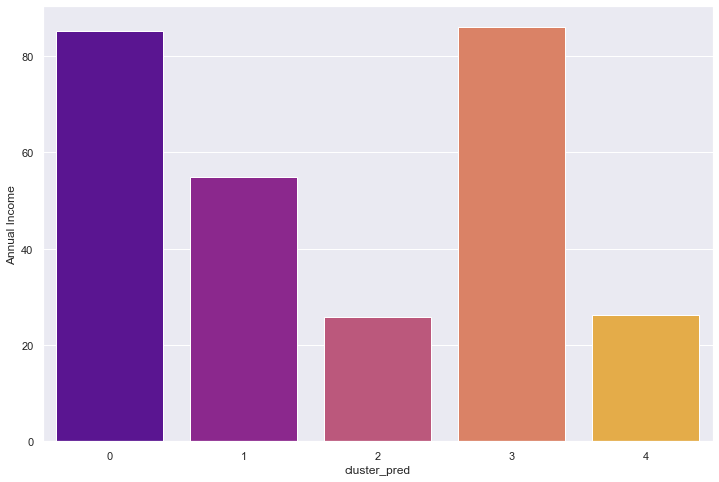

In [365]:
sns.barplot(x='cluster_pred',y='Annual Income',palette="plasma", data=avg_data)

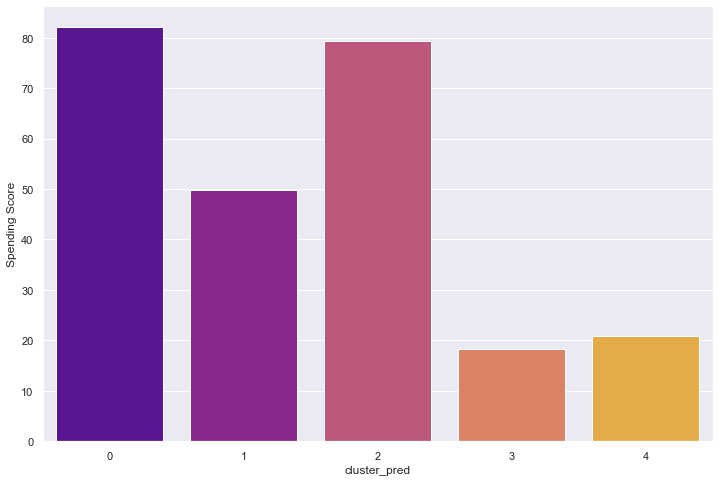

In [366]:
sns.barplot(x='cluster_pred',y='Spending Score',palette="plasma", data=avg_data)

## Gender Breakdown

We also need to understand the gender divide of each cluster.

In [367]:
#To understand the gender divide of each cluster
final_data = pd.DataFrame(clusters_new.groupby(['cluster_pred','Gender'])['Gender'].count())
final_data

Gender
cluster_pred Gender        
0            Female      21
             Male        17
1            Female      46
             Male        33
2            Female      13
             Male         9
3            Female      18
             Male        18
4            Female      14
             Male         9

Clusters 0,1,3,4 have a higher proportion of females than males and cluster 2 has an almost equal proportion of both.

# Final Analysis and Actions

Based on these data, the following hypotheses could be tested:

- Marketing cheaper items to women to see if they purchase more frequently or more volume.

- Marketing more to younger women because their spending score tends to be higher.

- Thinking up new ways to target advertising, pricing, branding, etc. to the older women (older than early 40s) who have lower spending scores.

- Figure out a way to gather more data to build a data set that has more features. The more features, the better understanding of what determines Spending Score. Once Spending Score is better understood, we can understand what factors will lead to increasing Spending Score, thus lead to greater profits.